
# Worker activity recognition

This Notebook provides a comprehensive workflow for worker activity recognition and classification in **Pick** and **NoPick** class. It can train the model in both GPU and CPU environment, and save the trained model. Additionally, it supports evaluating a pre-trained model on a test dataset.
- **Training a Model**: Set `train_val_test=True` to enable training and validation.
- **Evaluating a Pre-trained Model**: Set `train_val_test=False` to skip training and directly evaluate a pre-trained model.


In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format='retina'

from yieldnn2025 import YieldNN
from utils.misc import VelocityCalculator, CreateDataset

from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.metrics import confusion_matrix,precision_recall_curve, auc


import pytz


register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

2025-07-09 16:23:56.317265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 16:23:56.432657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 16:23:56.469104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 16:23:56.483434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 16:23:56.594994: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device_name=tf.test.gpu_device_name()
if device_name:
    print(f"GPU Available {device_name}")
else:
    print(f"No GPU !! {device_name}")

GPU Available /device:GPU:0


I0000 00:00:1752103446.596173   57198 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752103446.698503   57198 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752103446.698651   57198 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752103446.739978   57198 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
# Specify if using a trained model or training a new one
train_val_test=False  
if not train_val_test:
    #define the trained model path
    checkpoint_path="./weights/mass_imu_0210-1657"


### Reading and Combining Annotated Data

The annotated data from multiple CSV files is read and combined into a single DataFrame.

In [5]:

column_names = ['date_cartID','GPS_TOW','easting','northing', 'ax', 'ay', 'az', 'raw_mass', 'activity']
data_root="./datasets"
# Define the file paths and corresponding column names
file_paths = [
    "4-10-24_train-ready_all_carts.csv",
    "4-17-24_train-ready_all_carts.csv",
    "4-24-24_train-ready_all_carts.csv",
    "4-27-24_train-ready_all_carts.csv",
    "5-1-24_train-ready_all_carts.csv",
    "5-4-24_train-ready_all_carts.csv",
    "5-7-24_train-ready_all_carts.csv",
    "5-11-24_train-ready_all_carts.csv",
    "5-15-24_train-ready_all_carts.csv",
    "5-18-24_train-ready_all_carts.csv",
    "5-22-24_train-ready_all_carts.csv",
    "5-25-24_train-ready_all_carts.csv"
]
test_data="5-15-24" #"4-24-24", "5-4-24", "5-11-24", "5-15-24", "5-25-24"

dfs = []
for file_name in file_paths:
    file_path = os.path.join(data_root, "santa_maria_cnnlstm", file_name)
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path, usecols=column_names, on_bad_lines='skip').dropna()
        dfs.append(df_temp)
        print(f"Loaded file: {file_path} with shape {df_temp.shape}")
    else:
        print(f"File not found: {file_path}")

df = pd.concat(dfs).dropna()

Loaded file: ./datasets/santa_maria_cnnlstm/4-10-24_train-ready_all_carts.csv with shape (1278161, 9)
File not found: ./datasets/santa_maria_cnnlstm/4-17-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/4-24-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/4-27-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/5-1-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/5-4-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/5-7-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/5-11-24_train-ready_all_carts.csv
Loaded file: ./datasets/santa_maria_cnnlstm/5-15-24_train-ready_all_carts.csv with shape (5094841, 9)
File not found: ./datasets/santa_maria_cnnlstm/5-18-24_train-ready_all_carts.csv
File not found: ./datasets/santa_maria_cnnlstm/5-22-24_train-ready_all_carts.csv
Loaded file: ./datasets/santa_maria_cnnlstm/5-25-24_train-ready_all_ca

In [6]:
# calculate velocity
velocity_calculator = VelocityCalculator(df[['GPS_TOW', 'easting', 'northing']])
df["vel"],_, _ = velocity_calculator.calculate_velocity()
df = df.reset_index(drop=True).dropna()


In [7]:
df.head()

,date_cartID,GPS_TOW,easting,northing,ax,ay,az,raw_mass,activity,vel
0,4-10-24_Cart10,307568700.0,-10.254520,3.067013,-0.150886,0.795146,-10.061477,0.147245,NoPick,0.000000
1,4-10-24_Cart10,307568800.0,-10.254520,3.067013,-0.158071,0.780776,-10.061477,0.147151,NoPick,0.000000
2,4-10-24_Cart10,307568900.0,-10.259110,3.073547,-0.150886,0.795146,-10.049502,0.147516,NoPick,0.079848
3,4-10-24_Cart10,307569000.0,-10.264066,3.076789,-0.158071,0.792751,-10.059082,0.147563,NoPick,0.059223
4,4-10-24_Cart10,307569100.0,-10.266493,3.078769,-0.148491,0.797542,-10.054292,0.147583,NoPick,0.031325


In [8]:
print(df.describe())

            GPS_TOW       easting      northing            ax            ay  \
count  1.098766e+07  1.098766e+07  1.098766e+07  1.098766e+07  1.098766e+07   
mean   4.261183e+08 -9.076781e+01  8.707496e+01 -4.894133e-01  9.682193e-01   
std    1.288110e+08  6.435952e+01  4.512475e+01  1.499976e+00  1.832005e+00   
min    3.064646e+08 -2.065145e+02 -2.821624e+00 -4.324447e+01 -6.829398e+01   
25%    3.135194e+08 -1.506080e+02  5.585357e+01 -1.060994e+00  9.053174e-01   
50%    3.256509e+08 -8.062598e+01  9.122323e+01 -4.885840e-01  1.338816e+00   
75%    5.751043e+08 -2.886649e+01  1.173838e+02  5.987549e-02  1.724414e+00   
max    5.888810e+08  2.510745e+00  1.995052e+02  5.647217e+01  4.038242e+01   

                 az      raw_mass           vel  
count  1.098766e+07  1.098766e+07  1.098766e+07  
mean  -9.522779e+00  1.814458e+00  1.181817e-01  
std    1.460805e+00  1.784471e+00  9.677338e-01  
min   -7.803932e+01 -2.028908e+01  0.000000e+00  
25%   -9.917776e+00  6.501238e-02  1.7

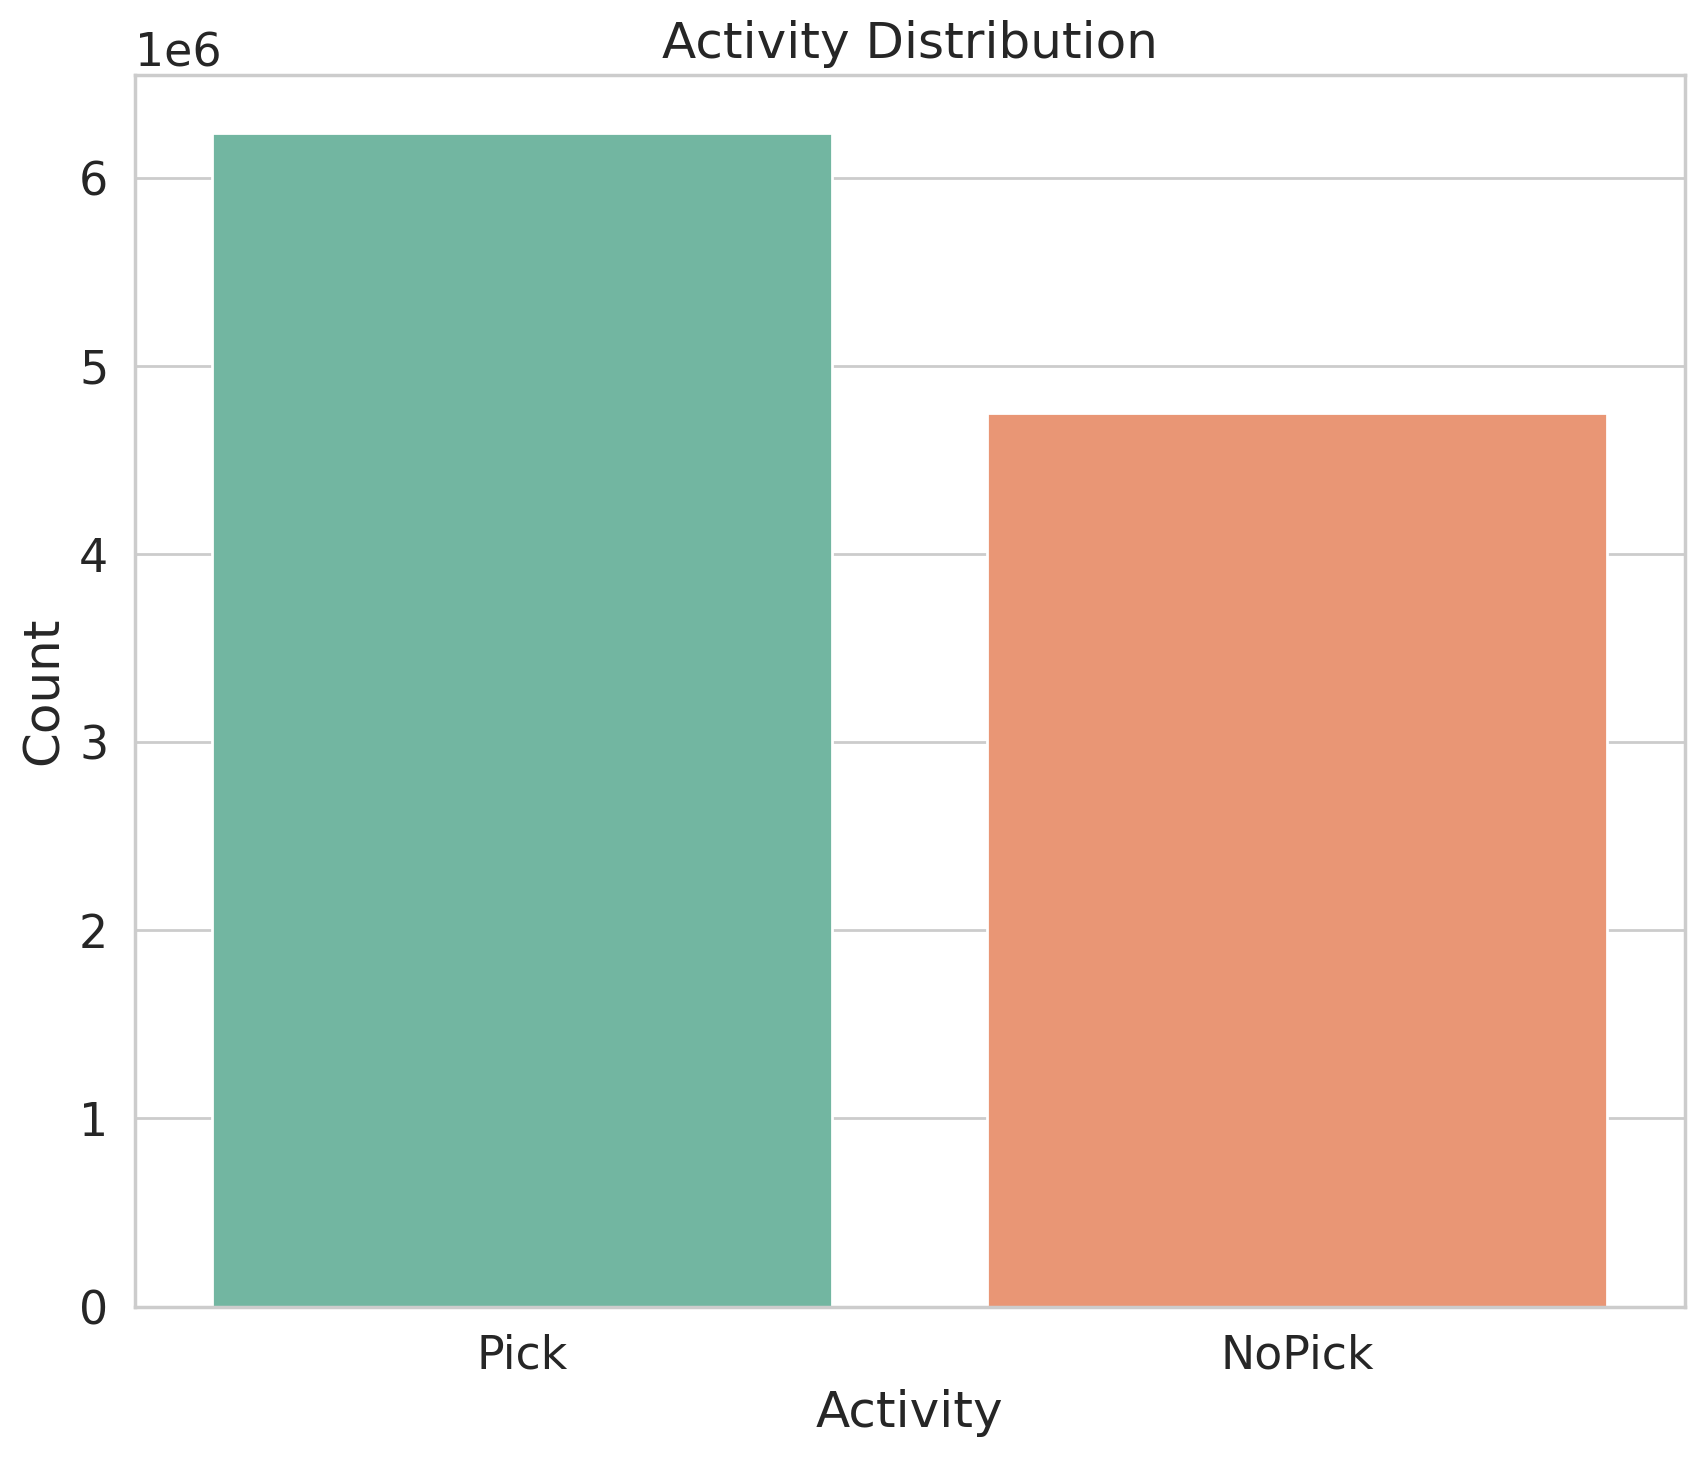

In [9]:
plt.figure(figsize=(10, 8))
sns.countplot(
    x='activity',
    data=df,
    order=df.activity.value_counts().index,
    palette='Set2'
)
plt.title('Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.show()

In [10]:
# Split the data into training and test sets based on the date_cartID
df_train=df[~df['date_cartID'].str.startswith(test_data)]
df_test=df[df['date_cartID'].str.startswith(test_data)]
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
print(f"Dataset shape: {df.shape},Train shape: {df_train.shape}, Test shape: {df_test.shape}")

Dataset shape: (10987663, 10),Train shape: (5892822, 10), Test shape: (5094841, 10)


In [11]:
train_mode= "mass_imu" #mass_imu_vel, mass_imu, mass, imu,vel

if train_mode=="mass_imu_vel":
    train_columns = ['vel','ax', 'ay', 'az','raw_mass']
if train_mode=="mass_imu":
    train_columns = ['ax', 'ay', 'az','raw_mass']
if train_mode=="mass":
    train_columns = ['raw_mass']
if train_mode=="imu":
    train_columns = ['ax', 'ay', 'az']
if train_mode=="vel":
    train_columns = ['vel']


In [12]:
# scaling the data
scaler = RobustScaler()
scaler = scaler.fit(df_train[train_columns])

df_train.loc[:, train_columns] = scaler.transform(df_train[train_columns].to_numpy())
df_test.loc[:, train_columns] = scaler.transform(df_test[train_columns].to_numpy())

In [13]:
TIME_STEPS = 9600  # Number of time steps in each segment
STEP_SIZE = 5000   # Step size for sliding window

X_train, y_train = CreateDataset.create_dataset(
    df_train[train_columns],
    df_train.activity,
    TIME_STEPS,
    STEP_SIZE
)

X_test, y_test = CreateDataset.create_dataset(
    df_test[train_columns],
    df_test.activity,
    TIME_STEPS,
    STEP_SIZE
)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(1177, 9600, 4) (1177, 96, 1)
(1018, 9600, 4) (1018, 96, 1)


In [15]:

enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

enc = enc.fit(y_train.reshape(-1,1))

y_train_encoded = enc.transform(y_train.reshape(-1,1))
y_train=y_train_encoded.reshape(-1,96,2)
y_test_encoded = enc.transform(y_test.reshape(-1,1))
y_test=y_test_encoded.reshape(-1,96,2)


In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1177, 9600, 4) (1177, 96, 2)
(1018, 9600, 4) (1018, 96, 2)


In [17]:

if train_val_test:
    # Can actually define the input shape based on the train data. However, keras requires better serialization. 
    # For now, if using different input shapes it is better to define the input shape explicitly in yieldnn2025.py
    # Example: mass_imu input shape is (9600, 4)
    model=YieldNN()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    #Defining checkpoint callback
    now = datetime.now(pytz.utc).astimezone(pytz.timezone('America/Los_Angeles'))
    checkpoint_path = os.path.join("./weights",train_mode+"_"+now.strftime("%m%d-%H%M"))
    print(f"Checkpoint file: {checkpoint_path}.keras")
    checkpoint_callback = ModelCheckpoint(checkpoint_path+".keras",
                                          monitor='val_loss',
                                          save_best_only=True,
                                          mode='min',
                                          verbose=1)
    
    # Fit the model
    # Model was trained in Google Colab with GPU, so we will use the same GPU settings. CPU training is also supported.
    if device_name:
        with tf.device(device_name):
        
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=270,
                validation_split=0.2,
                shuffle=True,
                callbacks=[checkpoint_callback]
            )
    else:
        history = model.fit(
            X_train, y_train,
            epochs=15,
            batch_size=60,
            validation_split=0.2,
            shuffle=True,
            callbacks=[checkpoint_callback]
        )

    

In [18]:
if train_val_test:
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

# Model Training Completed

In [19]:
# Load the best model from the checkpoint

model = tf.keras.models.load_model(checkpoint_path + ".keras") 


I0000 00:00:1746051381.282382  174170 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-30 15:16:21.282549: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
if device_name:
    with tf.device(device_name):
        model.evaluate(X_test, y_test)
        y_pred = model.predict(X_test)
else:

    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - acc: 0.9744 - loss: 0.0995
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step


In [21]:
# Defining the confusion matrix plot function
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(16, 12))
  ax = sns.heatmap(
      cm,
      annot=True,
      fmt="d",
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim()
  b += 0.5 
  t -= 0.5 
  plt.ylim(b, t) 
  plt.show() 
  return cm


In [22]:
y_test_flat = y_test.reshape(-1, 2)
y_pred_flat = y_pred.reshape(-1, 2)

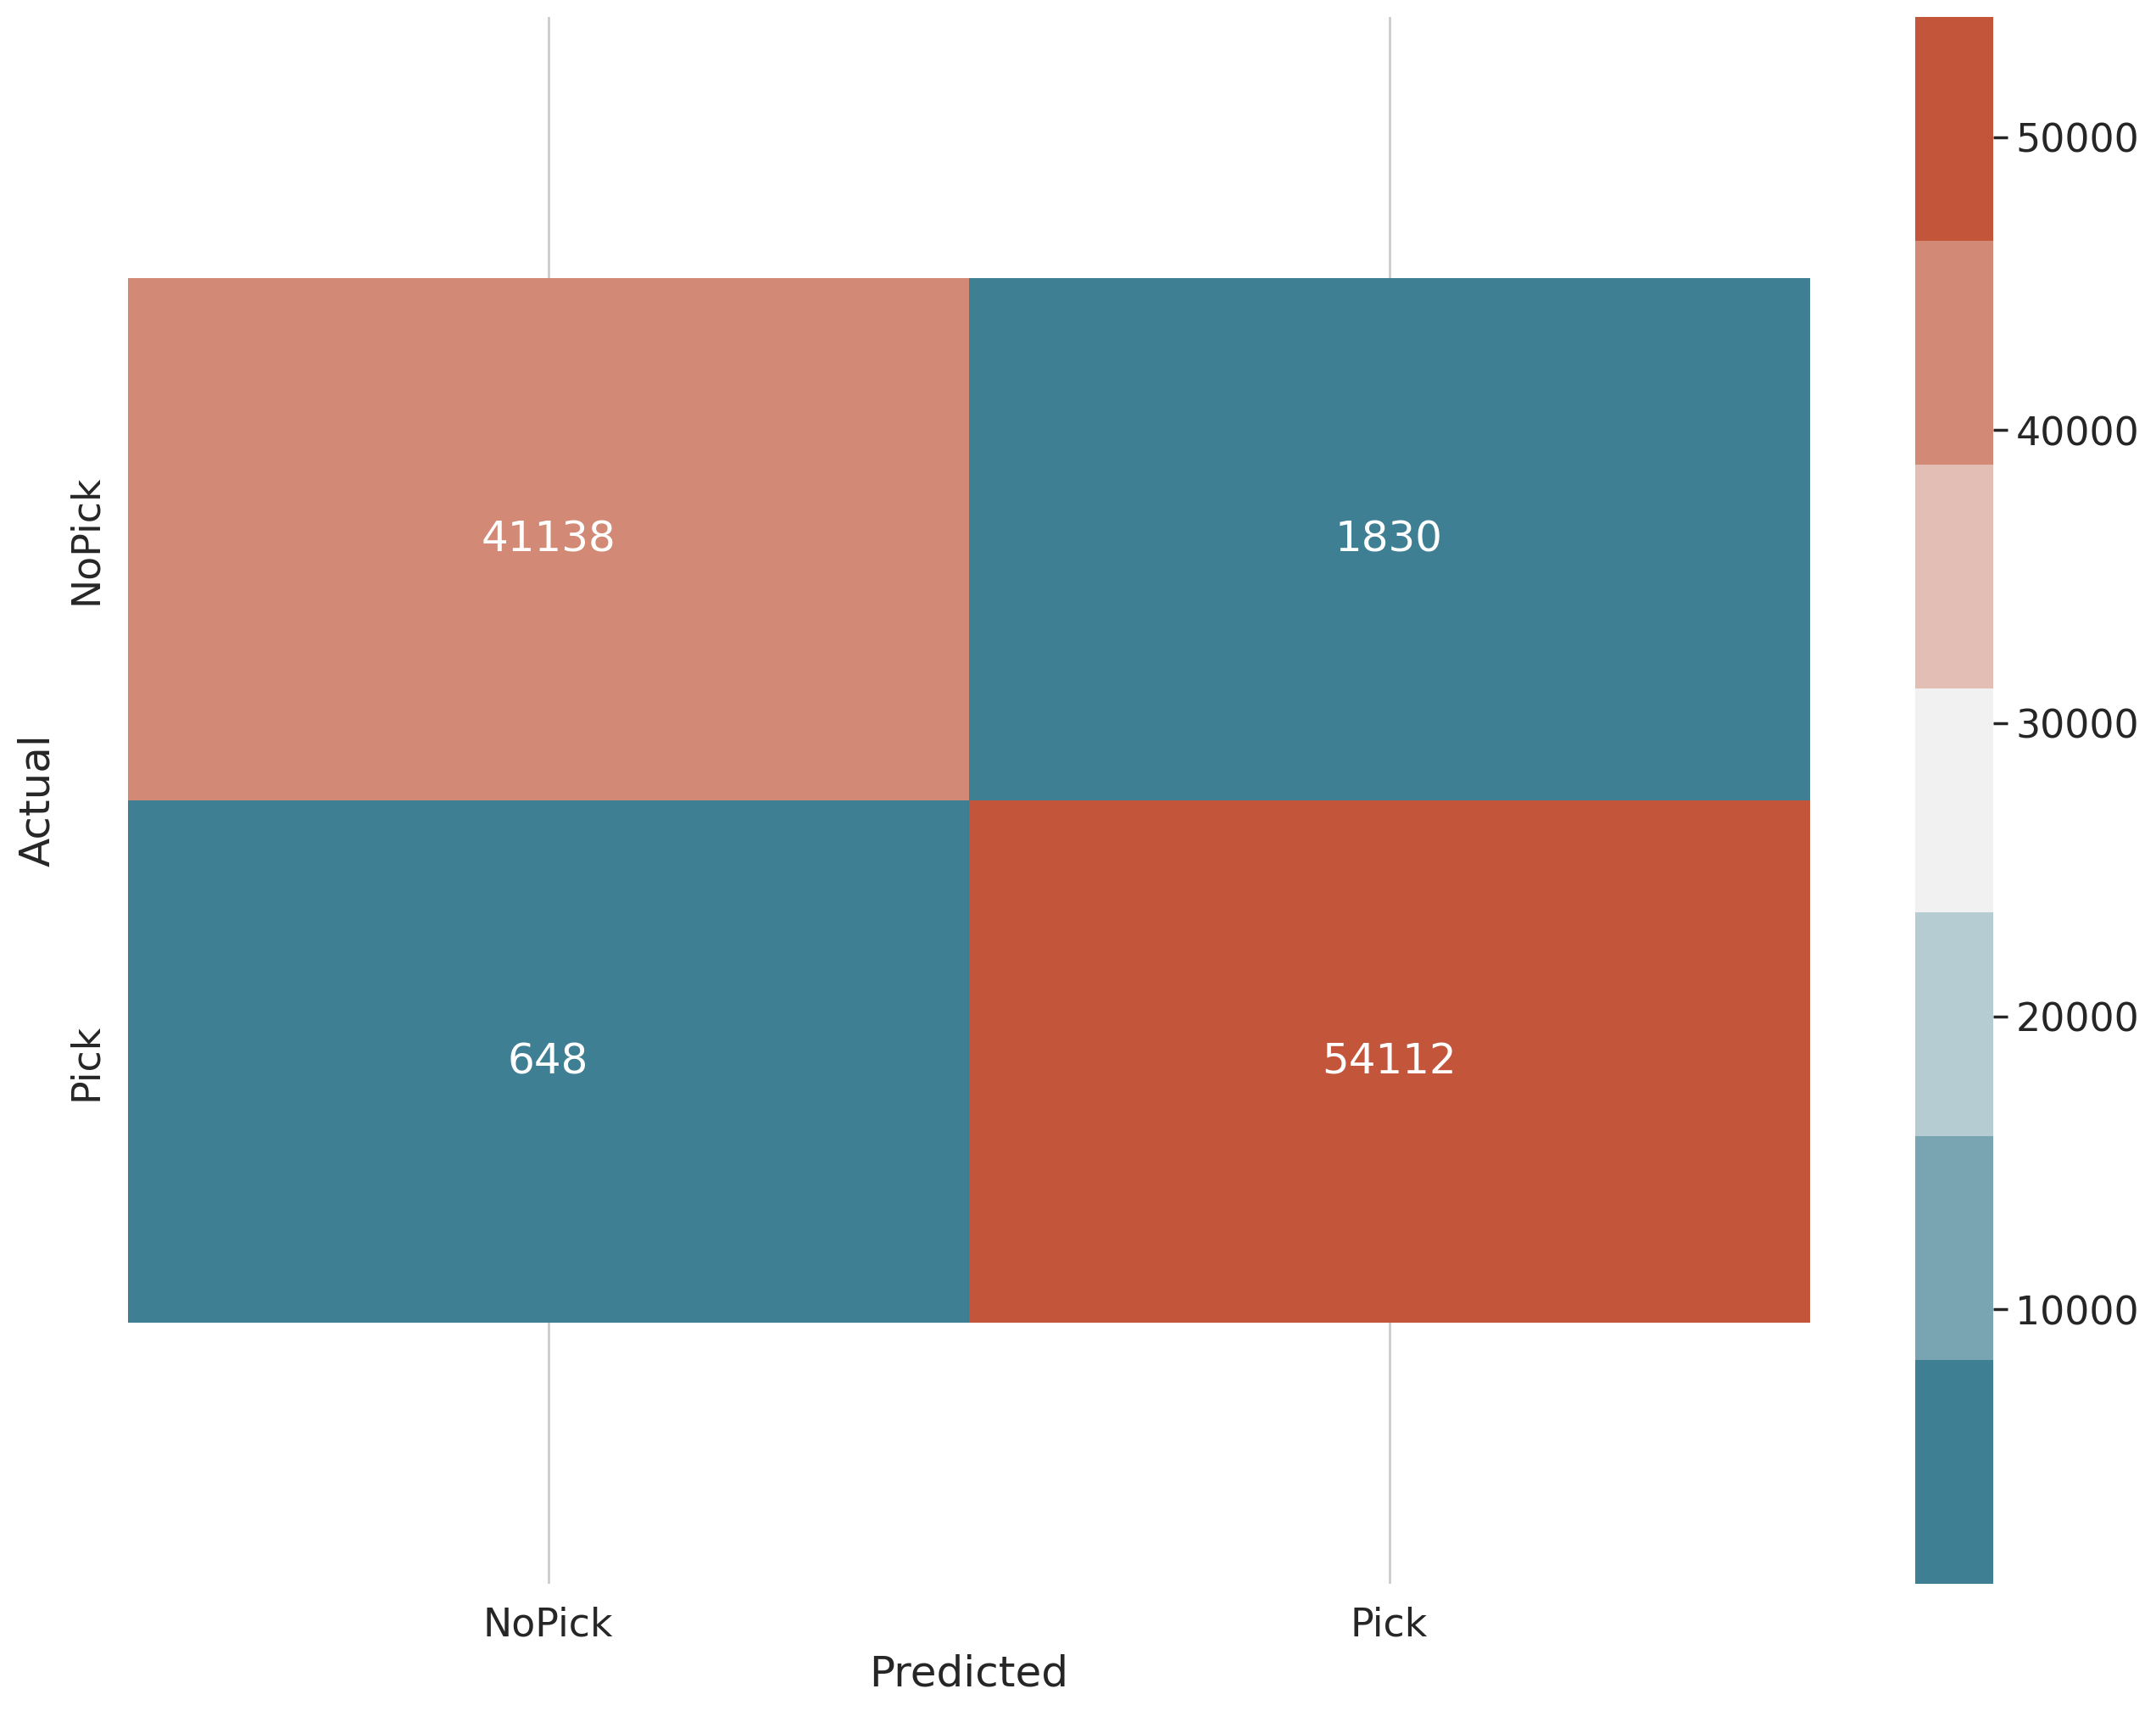

In [23]:
# plotting confusion matrix
conf_matrix=plot_cm(
  enc.inverse_transform(y_test_flat),
  enc.inverse_transform(y_pred_flat),
  enc.categories_[0]
)

class_categories=enc.categories_[0]

In [24]:
# precision recall F1 score metrics
print(f"Confusion matrix with categories {class_categories}:")
print(conf_matrix)
picking_precision=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1]) # (TP/TP+FP) Precision, considers events classified as picking but were actually not picking
picking_recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0]) #TP/TP+FN Recall, considers events classified as not picking but were actually picking
F1=2*(picking_precision*picking_recall)/(picking_precision+picking_recall)
print(f"Training Parameters: {train_columns}")
print(f"Picking precision {picking_precision} recall {picking_recall} F1 {F1}")

Confusion matrix with categories ['NoPick' 'Pick']:
[[41138  1830]
 [  648 54112]]
Training Parameters: ['ax', 'ay', 'az', 'raw_mass']
Picking precision 0.9672875478173822 recall 0.9881665449233017 F1 0.97761558056765


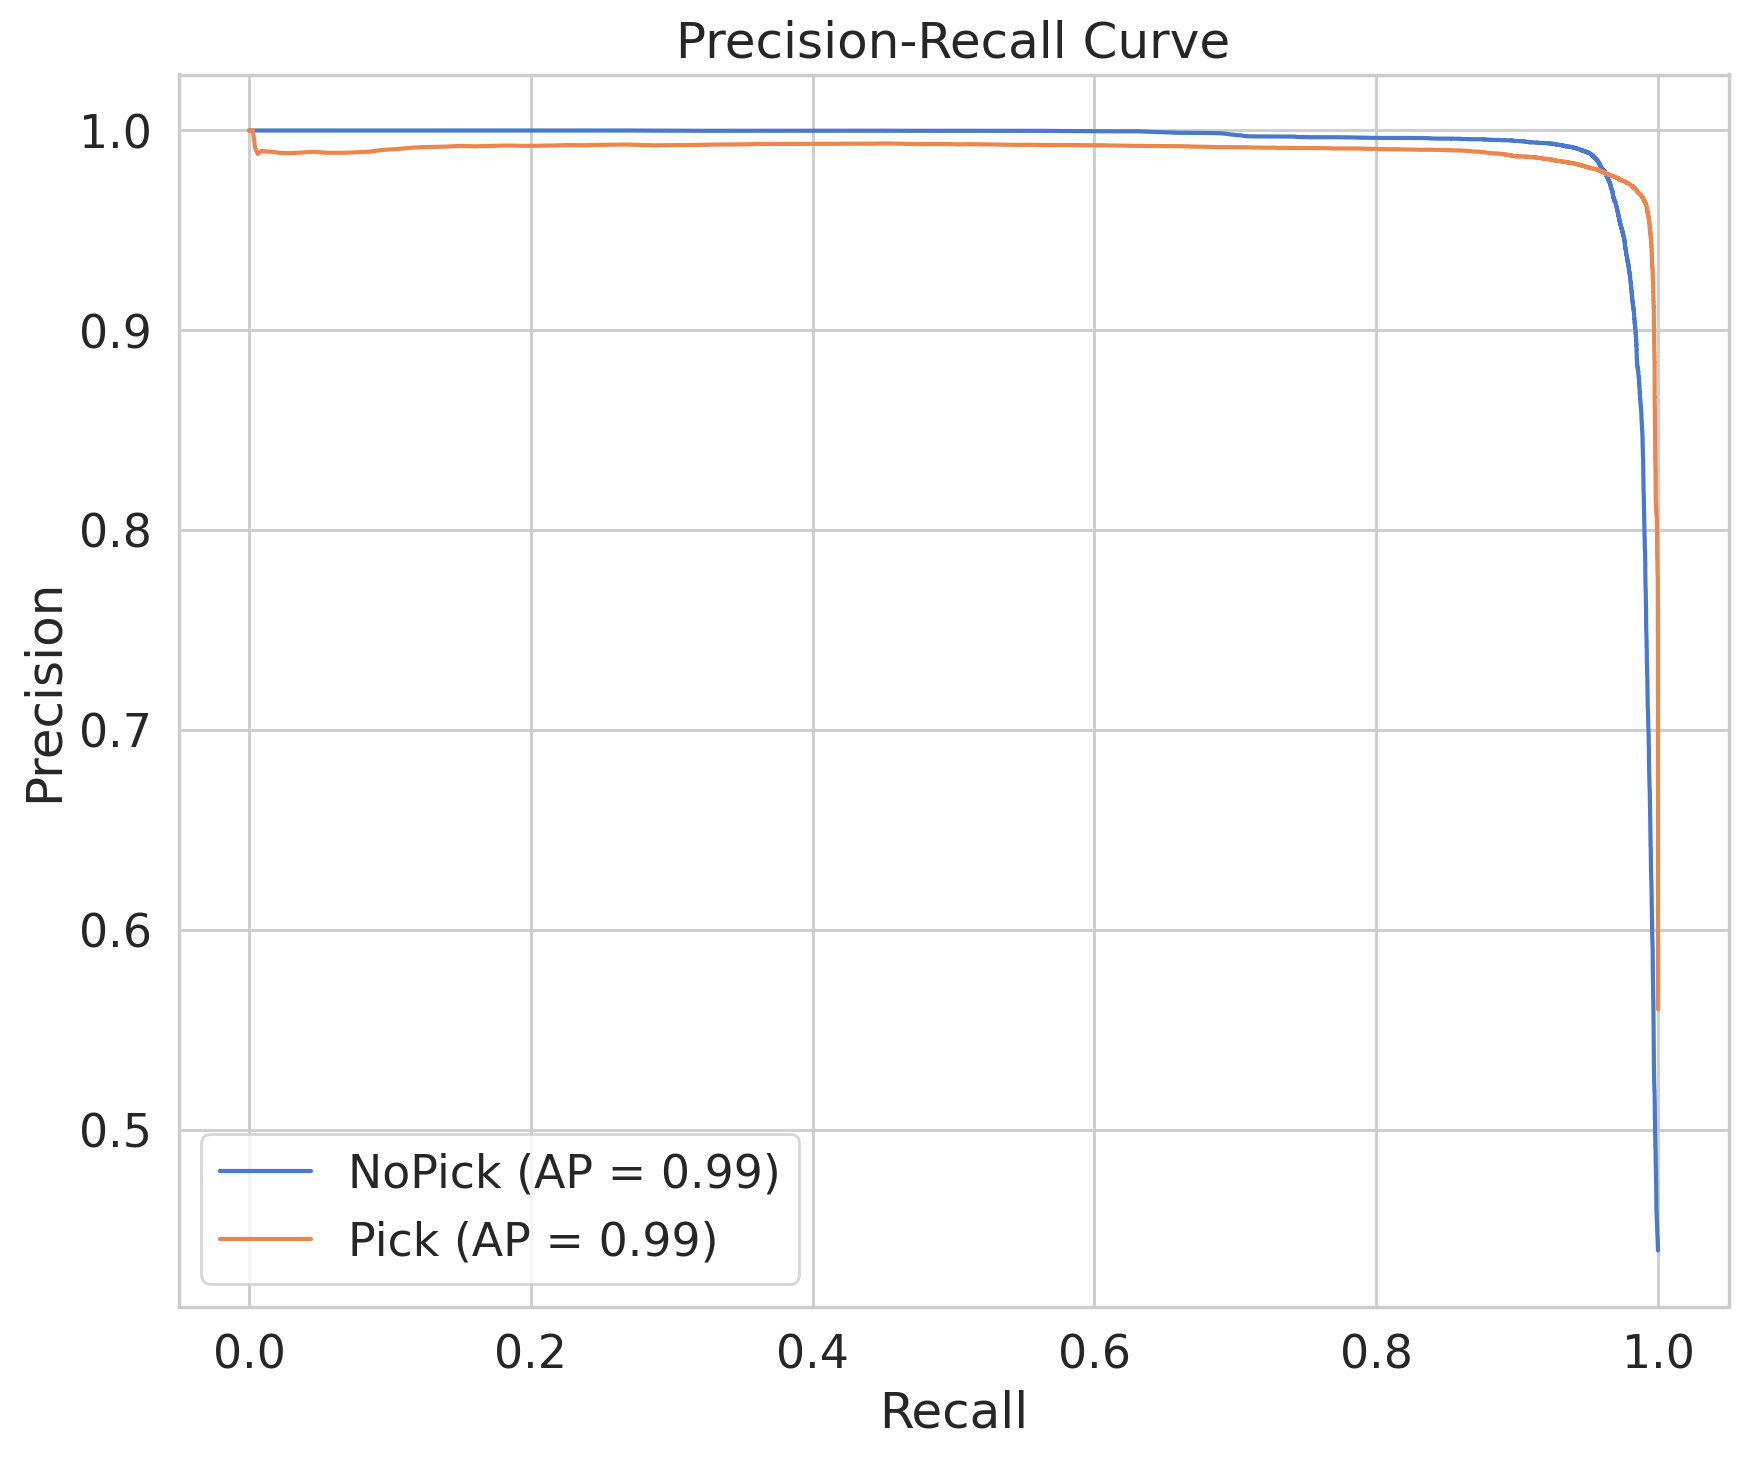

In [25]:
# Plot of precision recall curve
n_classes = y_test_flat.shape[1]

precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_flat[:, i], y_pred_flat[:, i])
    average_precision[i] = auc(recall[i], precision[i]) 

labels=["NoPick","Pick"]
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{labels[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
